In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.manifold import trustworthiness
import time
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, silhouette_score
from scipy.stats import mode
from sklearn.cluster import DBSCAN

# noms des 9 signaux
signals = ['accm_x', 'accm_y', 'accm_z',
           'acce_x', 'acce_y', 'acce_z',
           'vit_x', 'vit_y', 'vit_z']

# lecture des 9 fichiers
data = {}
for s in signals:
    data[s] = pd.read_csv(f'data_projet/{s}.txt', delim_whitespace=True, header=None)

# labels
labels = pd.read_csv('data_projet/lab.txt', header=None)
labels.columns = ['Label']

# Read activity labels file
activity = pd.read_csv('data_projet/activity_labels.txt', header=None, sep=' ')
activity.columns = ['Label', 'Activity']

# Convert to dictionary
activity_dict = activity.set_index('Label')['Activity'].to_dict()



/tmp/ipykernel_22215/512370771.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data[s] = pd.read_csv(f'data_projet/{s}.txt', delim_whitespace=True, header=None)
/tmp/ipykernel_22215/512370771.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data[s] = pd.read_csv(f'data_projet/{s}.txt', delim_whitespace=True, header=None)
/tmp/ipykernel_22215/512370771.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data[s] = pd.read_csv(f'data_projet/{s}.txt', delim_whitespace=True, header=None)
/tmp/ipykernel_22215/512370771.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data[s] = pd.read_csv(f'da

In [3]:
print(data.keys())
print(labels)
print(activity_dict)


dict_keys(['accm_x', 'accm_y', 'accm_z', 'acce_x', 'acce_y', 'acce_z', 'vit_x', 'vit_y', 'vit_z'])
     Label
0        5
1        5
2        5
3        5
4        5
..     ...
342      3
343      3
344      3
345      3
346      3

[347 rows x 1 columns]
{1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}


In [4]:
features = pd.DataFrame()

for s in signals:
    df = data[s]
    features[f'{s}_mean'] = df.mean(axis=1)
    features[f'{s}_std'] = df.std(axis=1)
    features[f'{s}_max'] = df.max(axis=1)
    features[f'{s}_min'] = df.min(axis=1)

print(features)

     accm_x_mean  accm_x_std  accm_x_max  accm_x_min  accm_y_mean  accm_y_std  \
0       1.019305    0.001798    1.024606    1.012817    -0.124262    0.003283   
1       1.019448    0.001940    1.024606    1.012893    -0.122936    0.004949   
2       1.019927    0.002915    1.027664    1.009013    -0.124997    0.006485   
3       1.020349    0.002584    1.027664    1.009013    -0.130493    0.004045   
4       1.020255    0.001956    1.026194    1.013645    -0.130209    0.003891   
..           ...         ...         ...         ...          ...         ...   
342     0.984560    0.323439    1.930545    0.537880    -0.281641    0.188059   
343     0.968589    0.331270    1.930545    0.423567    -0.271931    0.179947   
344     0.969117    0.323048    1.853018    0.247237    -0.278089    0.156070   
345     0.997426    0.327520    1.920519    0.247237    -0.254627    0.126044   
346     0.988306    0.335588    1.920519    0.402713    -0.231837    0.136554   

     accm_y_max  accm_y_min

In [5]:
print(f"{features.shape[0]} échantillons, {features.shape[1]} features")
print("Nombre de labels:", labels['Label'].nunique())


347 échantillons, 36 features
Nombre de labels: 6


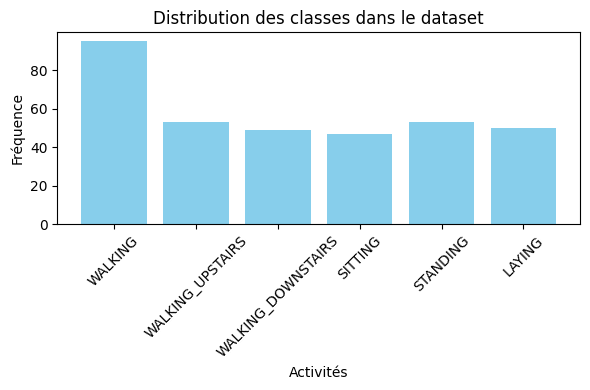

In [6]:
# Count occurrences of each label
counts = labels['Label'].value_counts().sort_index()

# Replace numeric index with activity names
activity_names = [activity_dict[i] for i in counts.index]

# Plot
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(activity_names, counts.values, color='skyblue')
ax.set_xlabel("Activités")
ax.set_ylabel("Fréquence")
ax.set_title("Distribution des classes dans le dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

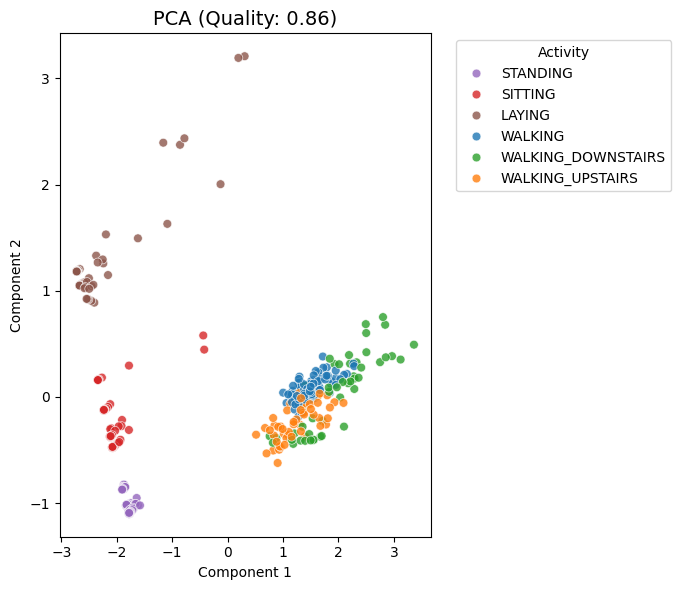

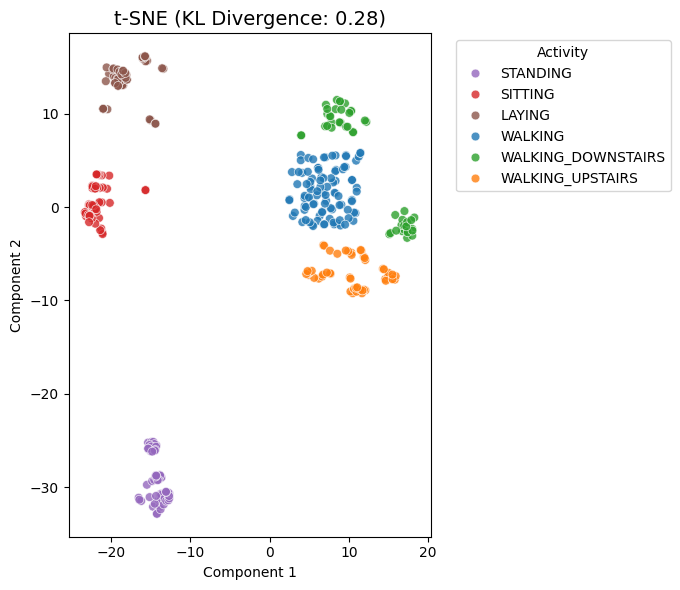

/home/lecteur/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


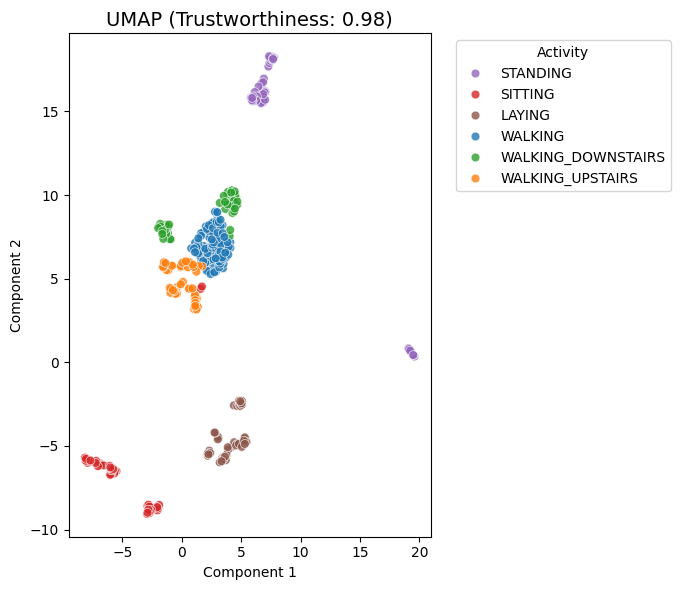

PCA quality: 0.86
t-SNE KL divergence: 0.28
UMAP trustworthiness: 0.98


In [ ]:

# Ensure results folder exists
os.makedirs("results", exist_ok=True)


activities = labels['Label'].map(activity_dict)

palette = sns.color_palette("tab10", len(activity_dict))
activity_colors = dict(zip(activity_dict.values(), palette))

#PCA
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(features)
pca_df = pd.DataFrame(pca_result, columns=['Dim1', 'Dim2'])
pca_df['Activity'] = activities

pca_quality = pca.explained_variance_ratio_.sum()

# Plot
plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=pca_df, x='Dim1', y='Dim2',
    hue='Activity', palette=activity_colors,
    s=40, alpha=0.8, legend='full'
)
plt.title(f"PCA (Quality: {pca_quality:.2f})", fontsize=14)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Activity", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("results/pca_plot.png", dpi=300)
plt.show()
plt.close()

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(features)
tsne_df = pd.DataFrame(tsne_result, columns=['Dim1', 'Dim2'])
tsne_df['Activity'] = activities

# Quality metric: KL divergence (lower is better)
tsne_quality = tsne.kl_divergence_

# Plot
plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=tsne_df, x='Dim1', y='Dim2',
    hue='Activity', palette=activity_colors,
    s=40, alpha=0.8, legend='full'
)
plt.title(f"t-SNE (KL Divergence: {tsne_quality:.2f})", fontsize=14)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Activity", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("results/tsne_plot.png", dpi=300)
plt.show()
plt.close()

# UMAP
reducer = umap.UMAP(min_dist=0.3, random_state=42)
umap_result = reducer.fit_transform(features)
umap_df = pd.DataFrame(umap_result, columns=['Dim1', 'Dim2'])
umap_df['Activity'] = activities

# Quality metric: trustworthiness (0–1, higher is better)
umap_quality = trustworthiness(features, umap_result, n_neighbors=5)

# Plot
plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=umap_df, x='Dim1', y='Dim2',
    hue='Activity', palette=activity_colors,
    s=40, alpha=0.8, legend='full'
)
plt.title(f"UMAP (Trustworthiness: {umap_quality:.2f})", fontsize=14)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Activity", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("results/umap_plot.png", dpi=300)
plt.show()
plt.close()


print(f"PCA quality: {pca_quality:.2f}")
print(f"t-SNE KL divergence: {tsne_quality:.2f}")
print(f"UMAP trustworthiness: {umap_quality:.2f}")


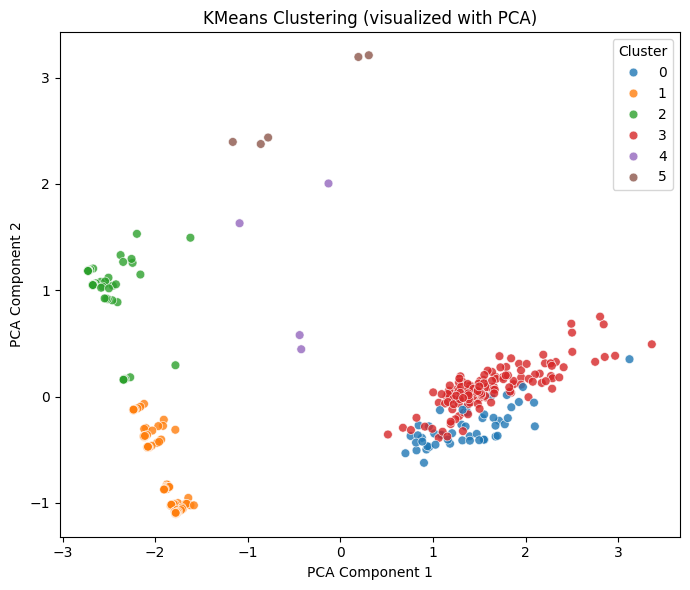

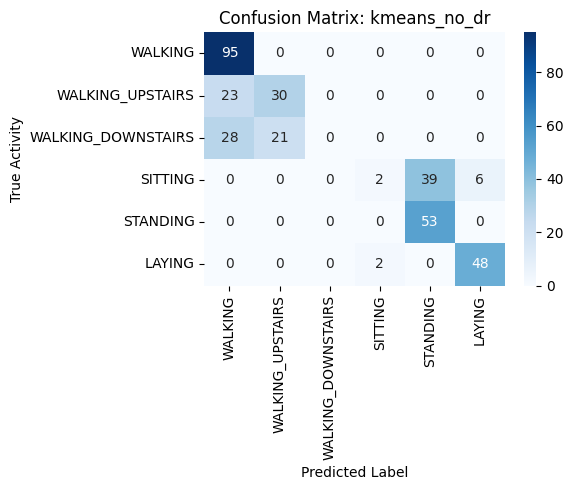

/home/lecteur/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


--- kmeans_no_dr ---
Accuracy: 0.657
WALKING -> Precision: 0.651, Recall: 1.000, F1: 0.788
WALKING_UPSTAIRS -> Precision: 0.588, Recall: 0.566, F1: 0.577
WALKING_DOWNSTAIRS -> Precision: 0.000, Recall: 0.000, F1: 0.000
SITTING -> Precision: 0.500, Recall: 0.043, F1: 0.078
STANDING -> Precision: 0.576, Recall: 1.000, F1: 0.731
LAYING -> Precision: 0.889, Recall: 0.960, F1: 0.923
Macro F1: 0.516
Silhouette Score: 0.427



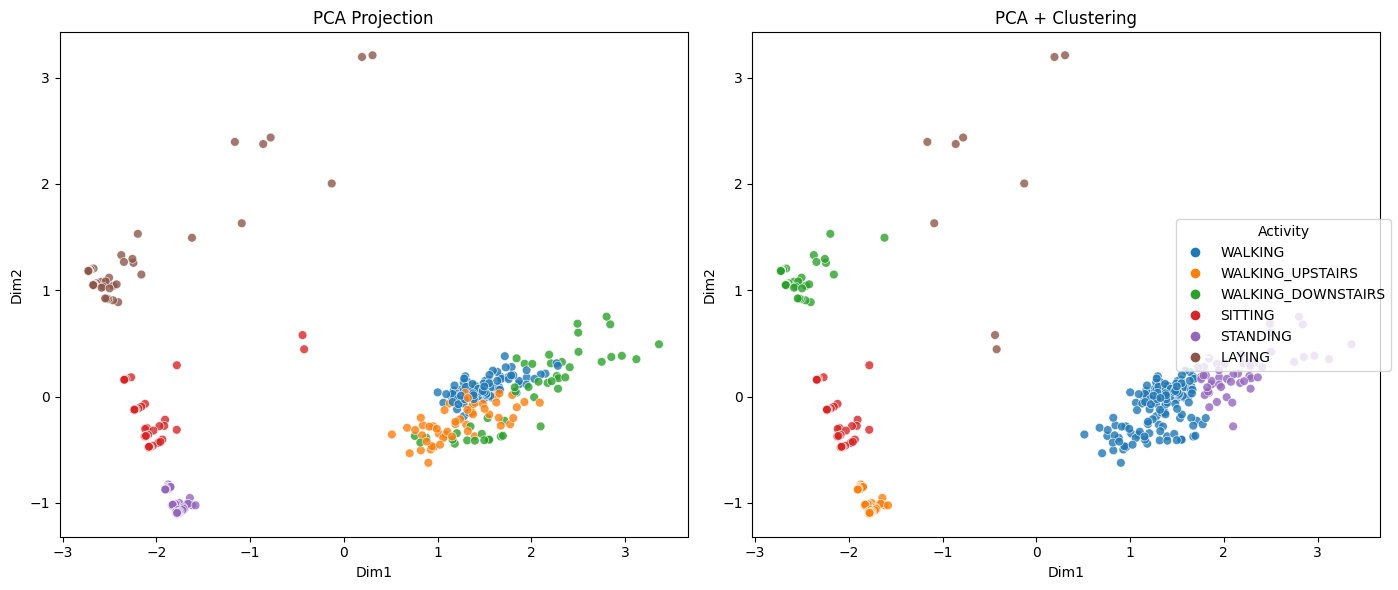

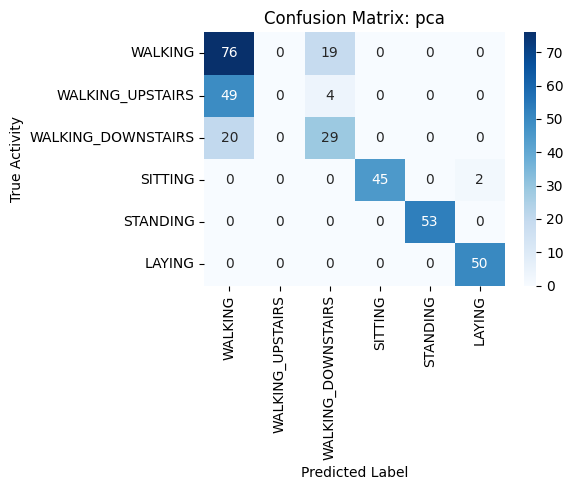

/home/lecteur/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


--- pca ---
Accuracy: 0.729
WALKING -> Precision: 0.524, Recall: 0.800, F1: 0.633
WALKING_UPSTAIRS -> Precision: 0.000, Recall: 0.000, F1: 0.000
WALKING_DOWNSTAIRS -> Precision: 0.558, Recall: 0.592, F1: 0.574
SITTING -> Precision: 1.000, Recall: 0.957, F1: 0.978
STANDING -> Precision: 1.000, Recall: 1.000, F1: 1.000
LAYING -> Precision: 0.962, Recall: 1.000, F1: 0.980
Macro F1: 0.694
Silhouette Score: 0.614



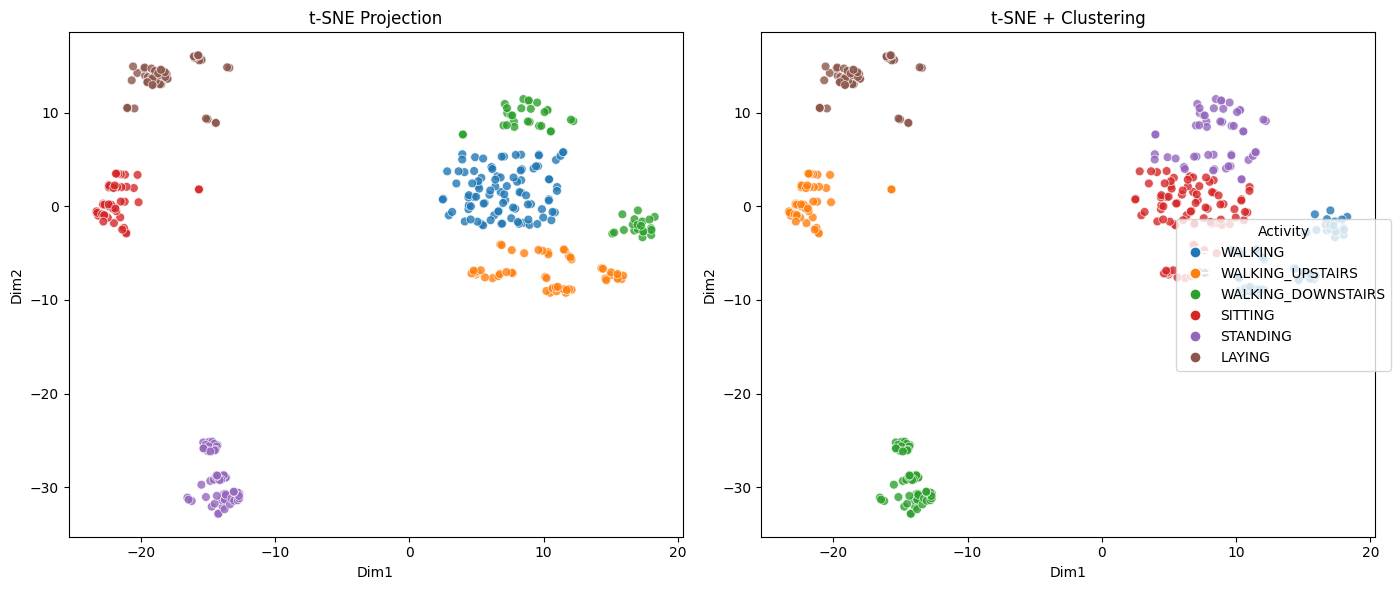

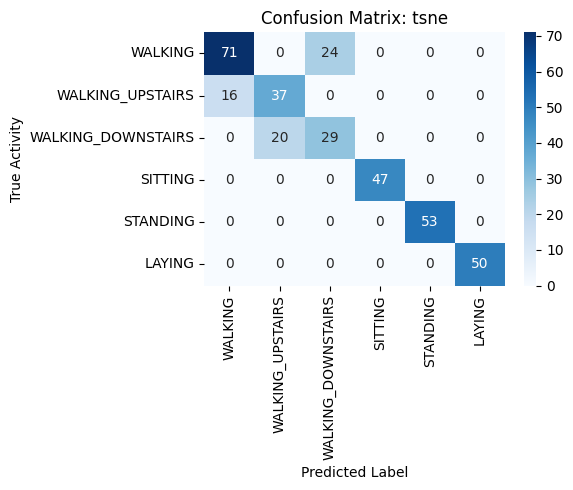

--- tsne ---
Accuracy: 0.827
WALKING -> Precision: 0.816, Recall: 0.747, F1: 0.780
WALKING_UPSTAIRS -> Precision: 0.649, Recall: 0.698, F1: 0.673
WALKING_DOWNSTAIRS -> Precision: 0.547, Recall: 0.592, F1: 0.569
SITTING -> Precision: 1.000, Recall: 1.000, F1: 1.000
STANDING -> Precision: 1.000, Recall: 1.000, F1: 1.000
LAYING -> Precision: 1.000, Recall: 1.000, F1: 1.000
Macro F1: 0.837
Silhouette Score: 0.588



/home/lecteur/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


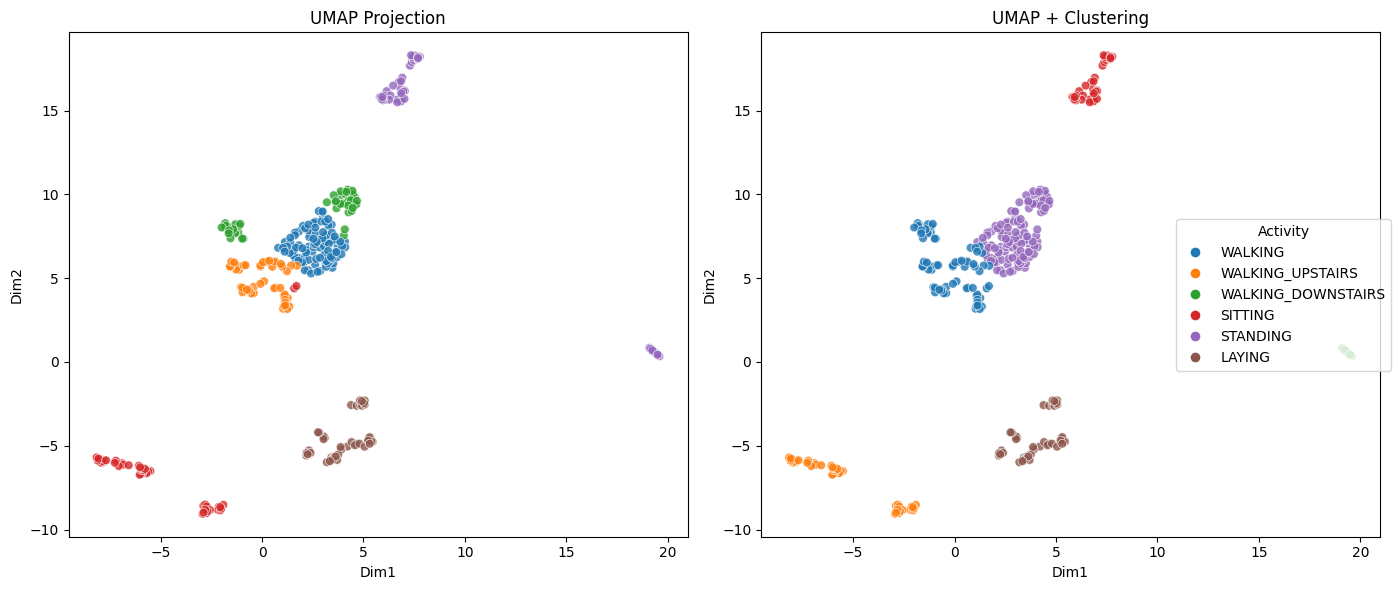

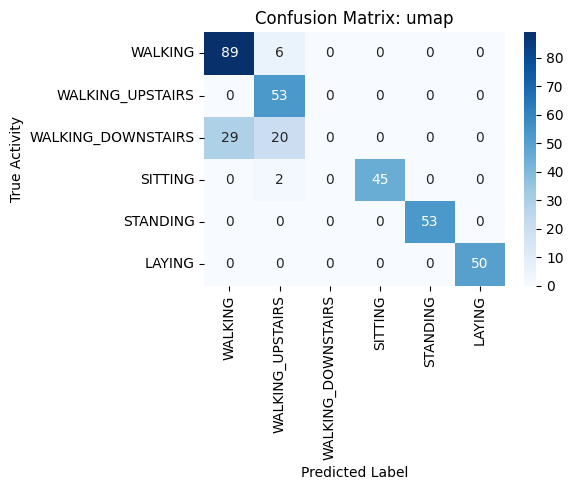

--- umap ---
Accuracy: 0.836
WALKING -> Precision: 0.754, Recall: 0.937, F1: 0.836
WALKING_UPSTAIRS -> Precision: 0.654, Recall: 1.000, F1: 0.791
WALKING_DOWNSTAIRS -> Precision: 0.000, Recall: 0.000, F1: 0.000
SITTING -> Precision: 1.000, Recall: 0.957, F1: 0.978
STANDING -> Precision: 1.000, Recall: 1.000, F1: 1.000
LAYING -> Precision: 1.000, Recall: 1.000, F1: 1.000
Macro F1: 0.767
Silhouette Score: 0.609

✅ All clustering + DR plots, confusion matrices, and numeric scores saved in 'results/' folder!


/home/lecteur/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:
# Ensure results folder exists
os.makedirs("results", exist_ok=True)

activities = labels['Label'].map(activity_dict)
palette = sns.color_palette("tab10", len(activity_dict))
activity_colors = dict(zip(activity_dict.values(), palette))

# ---------------------
def map_clusters_to_labels(true_labels, cluster_labels):
    mapped_labels = np.zeros_like(cluster_labels)
    for cluster in np.unique(cluster_labels):
        mask = cluster_labels == cluster
        majority_label = mode(true_labels[mask], keepdims=True).mode[0]
        mapped_labels[mask] = majority_label
    return mapped_labels

# ---------------------
def plot_dr_vs_cluster(X_dr, cluster_labels, title_dr, title_cluster, filename, activities, activity_colors):
    df = pd.DataFrame(X_dr, columns=['Dim1','Dim2'])
    df['Activity'] = activities
    df['Cluster'] = cluster_labels

    fig, axes = plt.subplots(1,2, figsize=(14,6))

    # DR only
    sns.scatterplot(x='Dim1', y='Dim2', hue='Activity', data=df,
                    palette=activity_colors, alpha=0.8, s=40, ax=axes[0])
    axes[0].set_title(title_dr)
    axes[0].set_xlabel("Dim1")
    axes[0].set_ylabel("Dim2")
    axes[0].legend_.remove()

    # DR + clustering
    sns.scatterplot(x='Dim1', y='Dim2', hue='Cluster', data=df,
                    palette='tab10', alpha=0.8, s=40, ax=axes[1])
    axes[1].set_title(title_cluster)
    axes[1].set_xlabel("Dim1")
    axes[1].set_ylabel("Dim2")
    axes[1].legend_.remove()

    handles = [plt.Line2D([0], [0], marker='o', color='w', label=act,
                          markerfacecolor=color, markersize=8)
               for act, color in activity_colors.items()]
    fig.legend(handles, activity_colors.keys(), title='Activity', loc='center right')
    plt.tight_layout()
    plt.savefig(f"results/{filename}", dpi=300)
    plt.show()
    plt.close()

# ---------------------
def plot_confusion_and_scores(true_labels, cluster_labels, X_features, filename_prefix):
    mapped_labels = map_clusters_to_labels(true_labels, cluster_labels)

    # Confusion matrix
    cm = confusion_matrix(true_labels, mapped_labels)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=activity_dict.values(),
                yticklabels=activity_dict.values())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Activity")
    plt.title(f"Confusion Matrix: {filename_prefix}")
    plt.tight_layout()
    plt.savefig(f"results/confusion_matrix_{filename_prefix}.png", dpi=300)
    plt.show()
    plt.close()

    # Scores
    acc = np.trace(cm) / np.sum(cm)
    precision = precision_score(true_labels, mapped_labels, average=None)
    recall = recall_score(true_labels, mapped_labels, average=None)
    f1 = f1_score(true_labels, mapped_labels, average=None)
    f1_macro = f1_score(true_labels, mapped_labels, average='macro')
    sil_score = silhouette_score(X_features, cluster_labels)

    print(f"--- {filename_prefix} ---")
    print(f"Accuracy: {acc:.3f}")
    for i, act in enumerate(activity_dict.values()):
        print(f"{act} -> Precision: {precision[i]:.3f}, Recall: {recall[i]:.3f}, F1: {f1[i]:.3f}")
    print(f"Macro F1: {f1_macro:.3f}")
    print(f"Silhouette Score: {sil_score:.3f}\n")

#Kmeans
kmeans_no_dr = KMeans(n_clusters=len(activity_dict), random_state=42)
kmeans_no_dr.fit(features)

# Visualize with PCA
pca_vis = PCA(n_components=2, random_state=42).fit_transform(features)
df_no_dr = pd.DataFrame(pca_vis, columns=['Dim1','Dim2'])
df_no_dr['Cluster'] = kmeans_no_dr.labels_

plt.figure(figsize=(7,6))
sns.scatterplot(x='Dim1', y='Dim2', data=df_no_dr,
                hue='Cluster', palette='tab10', s=40, alpha=0.8)
plt.title("KMeans Clustering (visualized with PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.savefig("results/kmeans_no_dr_plot.png", dpi=300)
plt.show()
plt.close()

plot_confusion_and_scores(labels['Label'], kmeans_no_dr.labels_, features, "kmeans_no_dr")

# kmeans + pca
pca_result = PCA(n_components=2, random_state=42).fit_transform(features)
kmeans_pca = KMeans(n_clusters=len(activity_dict), random_state=42).fit(pca_result)
plot_dr_vs_cluster(pca_result, kmeans_pca.labels_, "PCA Projection", "PCA + Clustering", "pca_vs_cluster.png", activities, activity_colors)
plot_confusion_and_scores(labels['Label'], kmeans_pca.labels_, pca_result, "pca")

#Kmeans + t-sne
tsne_result = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(features)
kmeans_tsne = KMeans(n_clusters=len(activity_dict), random_state=42).fit(tsne_result)
plot_dr_vs_cluster(tsne_result, kmeans_tsne.labels_, "t-SNE Projection", "t-SNE + Clustering", "tsne_vs_cluster.png", activities, activity_colors)
plot_confusion_and_scores(labels['Label'], kmeans_tsne.labels_, tsne_result, "tsne")

#Kmeans + UMAP
umap_result = umap.UMAP(min_dist=0.3, random_state=42).fit_transform(features)
kmeans_umap = KMeans(n_clusters=len(activity_dict), random_state=42).fit(umap_result)
plot_dr_vs_cluster(umap_result, kmeans_umap.labels_, "UMAP Projection", "UMAP + Clustering", "umap_vs_cluster.png", activities, activity_colors)
plot_confusion_and_scores(labels['Label'], kmeans_umap.labels_, umap_result, "umap")

print("✅ All clustering + DR plots, confusion matrices, and numeric scores saved in 'results/' folder!")


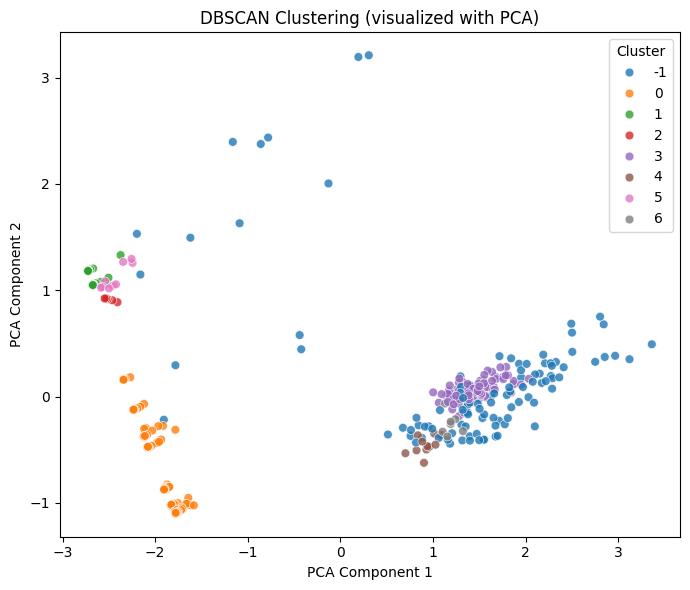

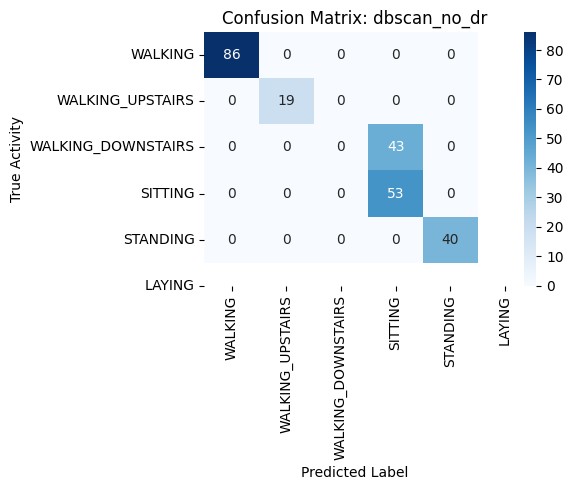

/home/lecteur/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


--- dbscan_no_dr ---
Accuracy: 0.822
WALKING -> Precision: 1.000, Recall: 1.000, F1: 1.000
WALKING_UPSTAIRS -> Precision: 1.000, Recall: 1.000, F1: 1.000
SITTING -> Precision: 0.000, Recall: 0.000, F1: 0.000
STANDING -> Precision: 0.552, Recall: 1.000, F1: 0.711
LAYING -> Precision: 1.000, Recall: 1.000, F1: 1.000
Macro F1: 0.742
Silhouette Score: 0.606



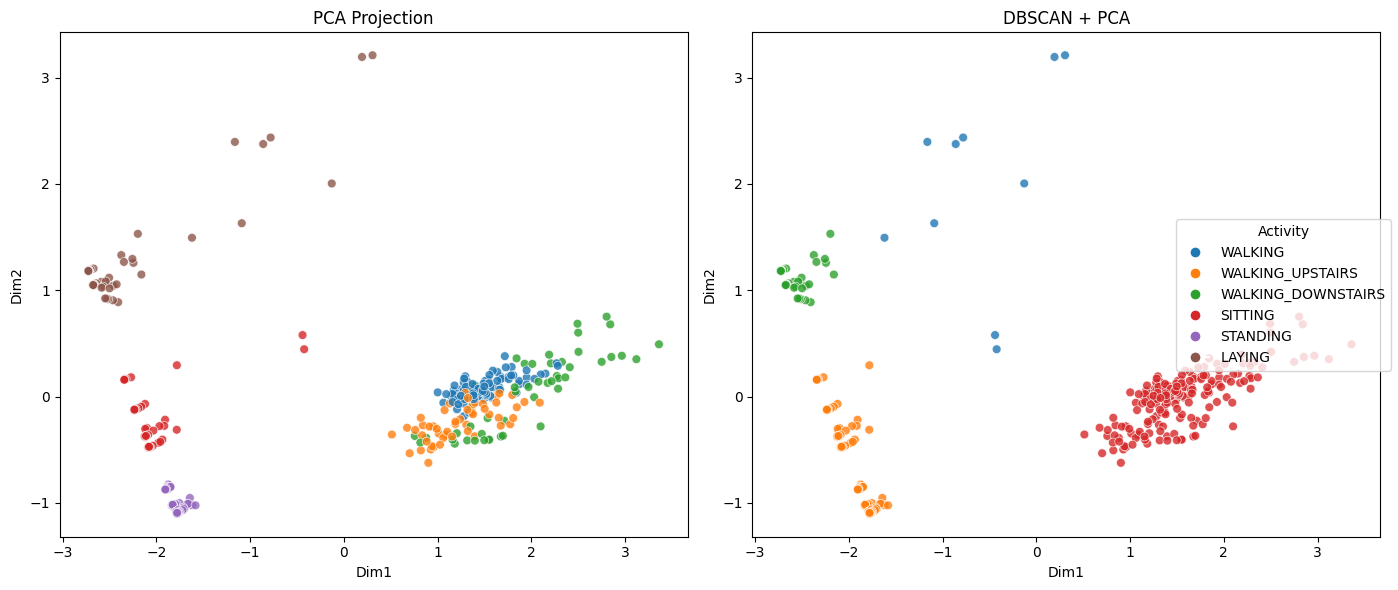

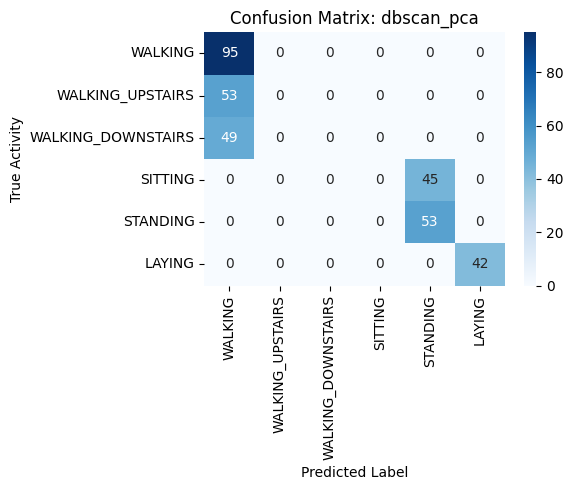

/home/lecteur/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


--- dbscan_pca ---
Accuracy: 0.564
WALKING -> Precision: 0.482, Recall: 1.000, F1: 0.651
WALKING_UPSTAIRS -> Precision: 0.000, Recall: 0.000, F1: 0.000
WALKING_DOWNSTAIRS -> Precision: 0.000, Recall: 0.000, F1: 0.000
SITTING -> Precision: 0.000, Recall: 0.000, F1: 0.000
STANDING -> Precision: 0.541, Recall: 1.000, F1: 0.702
LAYING -> Precision: 1.000, Recall: 1.000, F1: 1.000
Macro F1: 0.392
Silhouette Score: 0.793



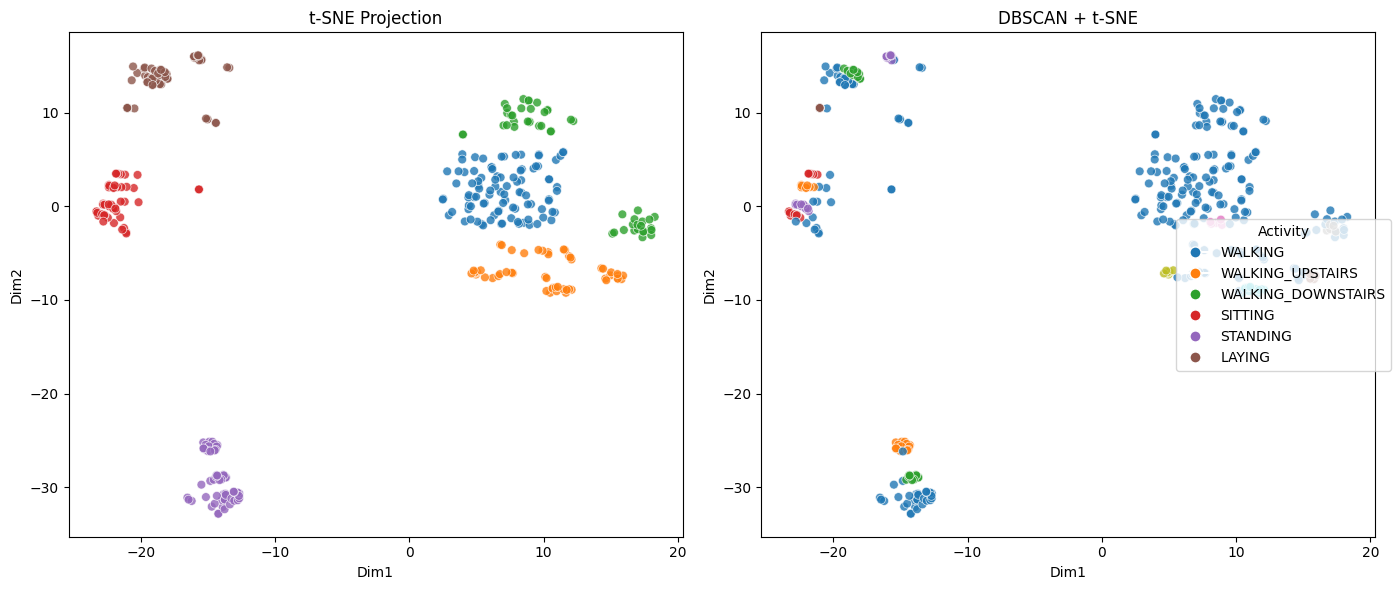

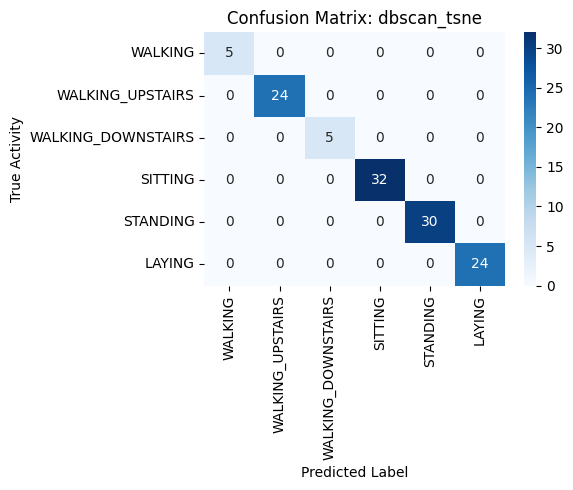

--- dbscan_tsne ---
Accuracy: 1.000
WALKING -> Precision: 1.000, Recall: 1.000, F1: 1.000
WALKING_UPSTAIRS -> Precision: 1.000, Recall: 1.000, F1: 1.000
WALKING_DOWNSTAIRS -> Precision: 1.000, Recall: 1.000, F1: 1.000
SITTING -> Precision: 1.000, Recall: 1.000, F1: 1.000
STANDING -> Precision: 1.000, Recall: 1.000, F1: 1.000
LAYING -> Precision: 1.000, Recall: 1.000, F1: 1.000
Macro F1: 1.000
Silhouette Score: 0.790



/home/lecteur/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


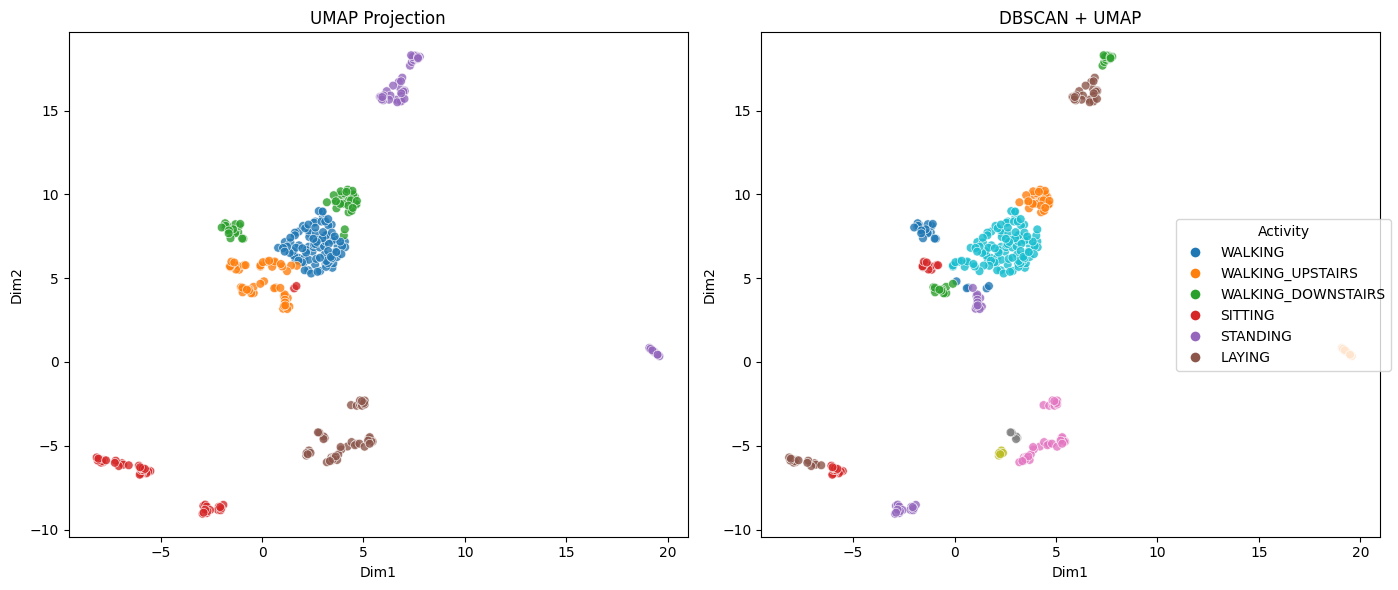

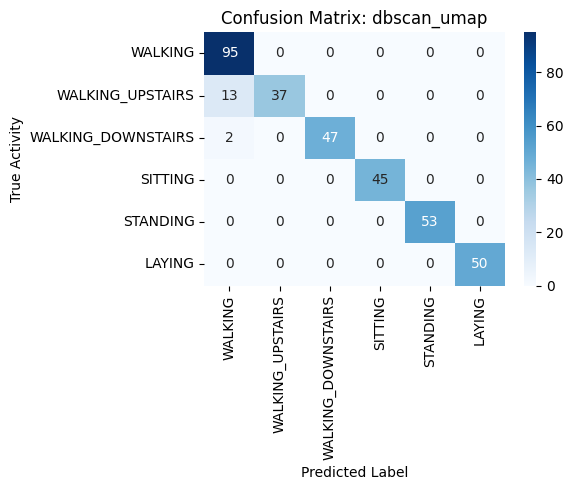

--- dbscan_umap ---
Accuracy: 0.956
WALKING -> Precision: 0.864, Recall: 1.000, F1: 0.927
WALKING_UPSTAIRS -> Precision: 1.000, Recall: 0.740, F1: 0.851
WALKING_DOWNSTAIRS -> Precision: 1.000, Recall: 0.959, F1: 0.979
SITTING -> Precision: 1.000, Recall: 1.000, F1: 1.000
STANDING -> Precision: 1.000, Recall: 1.000, F1: 1.000
LAYING -> Precision: 1.000, Recall: 1.000, F1: 1.000
Macro F1: 0.959
Silhouette Score: 0.582

✅ All DBSCAN clustering + DR plots, confusion matrices, and numeric scores saved in 'results/' folder!


In [ ]:
# DBSCAN without DR
dbscan_no_dr = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
dbscan_labels = dbscan_no_dr.fit_predict(features)

# Visualize with PCA
pca_vis = PCA(n_components=2, random_state=42).fit_transform(features)
df_dbscan = pd.DataFrame(pca_vis, columns=['Dim1','Dim2'])
df_dbscan['Cluster'] = dbscan_labels

plt.figure(figsize=(7,6))
sns.scatterplot(x='Dim1', y='Dim2', data=df_dbscan,
                hue='Cluster', palette='tab10', s=40, alpha=0.8)
plt.title("DBSCAN Clustering (visualized with PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.savefig("results/dbscan_no_dr_plot.png", dpi=300)
plt.show()
plt.close()

def plot_confusion_and_scores_dbscan(true_labels, cluster_labels, X_features, filename_prefix):
    # Remove noise points (-1)
    mask = cluster_labels != -1
    cluster_labels_valid = cluster_labels[mask]
    true_labels_valid = true_labels[mask]
    X_features_valid = X_features[mask]

    if len(np.unique(cluster_labels_valid)) == 0:
        print(f"No clusters found for {filename_prefix}")
        return

    mapped_labels = map_clusters_to_labels(true_labels_valid, cluster_labels_valid)

    # Confusion matrix
    cm = confusion_matrix(true_labels_valid, mapped_labels)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=activity_dict.values(),
                yticklabels=activity_dict.values())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Activity")
    plt.title(f"Confusion Matrix: {filename_prefix}")
    plt.tight_layout()
    plt.savefig(f"results/confusion_matrix_{filename_prefix}.png", dpi=300)
    plt.show()
    plt.close()

    # Scores
    acc = np.trace(cm) / np.sum(cm)
    precision = precision_score(true_labels_valid, mapped_labels, average=None, labels=np.unique(true_labels_valid))
    recall = recall_score(true_labels_valid, mapped_labels, average=None, labels=np.unique(true_labels_valid))
    f1 = f1_score(true_labels_valid, mapped_labels, average=None, labels=np.unique(true_labels_valid))
    f1_macro = f1_score(true_labels_valid, mapped_labels, average='macro')
    sil_score = silhouette_score(X_features_valid, cluster_labels_valid)

    # Map metrics to class names safely
    class_labels_present = np.unique(true_labels_valid)
    print(f"--- {filename_prefix} ---")
    print(f"Accuracy: {acc:.3f}")
    for i, label in enumerate(class_labels_present):
        act_name = activity_dict[label]
        print(f"{act_name} -> Precision: {precision[i]:.3f}, Recall: {recall[i]:.3f}, F1: {f1[i]:.3f}")
    print(f"Macro F1: {f1_macro:.3f}")
    print(f"Silhouette Score: {sil_score:.3f}\n")


plot_confusion_and_scores_dbscan(labels['Label'].values, dbscan_labels, features, "dbscan_no_dr")


# DBSCAN + PCA

pca_result = PCA(n_components=2, random_state=42).fit_transform(features)
dbscan_pca = DBSCAN(eps=0.5, min_samples=5, metric='euclidean').fit(pca_result)

plot_dr_vs_cluster(pca_result, dbscan_pca.labels_, "PCA Projection", "DBSCAN + PCA", "dbscan_pca_vs_cluster.png", activities, activity_colors)
plot_confusion_and_scores_dbscan(labels['Label'].values, dbscan_pca.labels_, pca_result, "dbscan_pca")


# DBSCAN + t-SNE

tsne_result = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(features)
dbscan_tsne = DBSCAN(eps=0.5, min_samples=5, metric='euclidean').fit(tsne_result)

plot_dr_vs_cluster(tsne_result, dbscan_tsne.labels_, "t-SNE Projection", "DBSCAN + t-SNE", "dbscan_tsne_vs_cluster.png", activities, activity_colors)
plot_confusion_and_scores_dbscan(labels['Label'].values, dbscan_tsne.labels_, tsne_result, "dbscan_tsne")

# DBSCAN + UMAP
umap_result = umap.UMAP(min_dist=0.3, random_state=42).fit_transform(features)
dbscan_umap = DBSCAN(eps=0.5, min_samples=5, metric='euclidean').fit(umap_result)

plot_dr_vs_cluster(umap_result, dbscan_umap.labels_, "UMAP Projection", "DBSCAN + UMAP", "dbscan_umap_vs_cluster.png", activities, activity_colors)
plot_confusion_and_scores_dbscan(labels['Label'].values, dbscan_umap.labels_, umap_result, "dbscan_umap")

print("✅ All DBSCAN clustering + DR plots, confusion matrices, and numeric scores saved in 'results/' folder!")
